In [1]:
import os
os.chdir('/mpqa/KBQA/src')
from setup import IndexSearch, Mongo_Connector

e_index = IndexSearch('dbpedia201604e')
p_index = IndexSearch('dbpedia201604p')

import json
from collections import Counter

### LC-QUAD

In [2]:
mongo = Mongo_Connector('kbqa', 'lcquad')
os.chdir("/mpqa/KBQA/data/lcquad")
lcquad_path = "lcquad_answers.json"
mongo.load_json(lcquad_path)
mongo.count_all_docs()
doc = mongo.get_sample(limit=1).next()
doc

Inserting 4998 new docs
4998 docs


{'_id': ObjectId('6113e80e05bab6096f8dc910'),
 'sparql_id': '301',
 'question': 'Which comic characters are painted by Bill Finger?',
 'SerialNumber': '1',
 'sparql_query': 'SELECT DISTINCT ?uri WHERE {?uri <http://dbpedia.org/ontology/creator> <http://dbpedia.org/resource/Bill_Finger>  . ?uri <http://www.w3.org/1999/02/22-rdf-syntax-ns#type> <http://dbpedia.org/ontology/ComicsCharacter>}',
 'checked': 'true',
 'entity mapping': [{'label': 'Bill Finger',
   'matchedBy': 'spotlight',
   'uri': 'http://dbpedia.org/resource/Bill_Finger',
   'seq': '38,49'}],
 'id': 'f0a9f1ca14764095ae089b152e0e7f12',
 'predicate mapping': [{'label': 'painted by',
   'uri': 'http://dbpedia.org/ontology/creator',
   'seq': '27,37',
   'mappedBy': 'manual corrections'},
  {'label': 'comic characters',
   'uri': 'http://dbpedia.org/ontology/ComicsCharacter',
   'seq': '6,22',
   'mappedBy': 'manual corrections'}],
 'answers': ['http://dbpedia.org/resource/Batman',
  'http://dbpedia.org/resource/Alfred_Pennywo

In [3]:
# reproduce the original lcquad test/train splits
limit = None
lcquad_train_path = 'train-data.json'  # wget https://raw.githubusercontent.com/AskNowQA/LC-QuAD/data/train-data.json

X_train = []
   
with open(lcquad_train_path, "r") as json_file:
    docs = json.load(json_file)
    for doc in docs:
        X_train.append(str(int(doc['_id']) + 1))
    print("%d docs loaded"%len(docs))

print("%d train samples" % (len(X_train)))
# annotate
samples = mongo.get_sample(limit=limit)
train_count = 0
for doc in samples:
    if doc['SerialNumber'] in X_train:
        doc['train'] = True
        train_count += 1
    else:
        doc['train'] = False
    mongo.col.update_one({'_id': doc['_id']}, {"$set": doc}, upsert=True)
print("Train: {}, Test: {}".format(train_count, samples.count() - train_count))
sample = mongo.get_sample(limit=1)[100]
print(sample['train'])

4000 docs loaded
4000 train samples
Train: 3999, Test: 999
True


/mpqa/miniconda3/envs/kbqa/lib/python3.6/site-packages/ipykernel_launcher.py:24: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.


In [4]:
# annotate GS entities and predicates across hops
# parse entities and predicates annotations across hops from the SQL query and update MongoDB collection
verbose = False
limit = None

samples = mongo.get_sample(limit=limit)
count = 0
for doc in samples:
    # fix URI !
    sparql_query = doc['sparql_query']
    # parse the SPARQL query into spo triples
    tripples = sparql_query[sparql_query.find("{")+1:sparql_query.find("}")].split('. ')

    # collect entities and predicates separately for 2 hops
    correct_intermediate_predicates = []
    correct_intermediate_entities = []
    correct_question_predicates = []
    correct_question_entities = []

    for tripple in tripples:
        if tripple:
            entities = []
            s, p, o = tripple.strip().split()
            if s[0] != '?':
                entities.append(s[1:-1])
            if o[0] != '?':
                entities.append(o[1:-1])
            p = p[1:-1]

            if '?uri' not in tripple:
                correct_intermediate_predicates.append(p)
                correct_intermediate_entities.extend(entities)
            else:
                correct_question_predicates.append(p)
                correct_question_entities.extend(entities)
    if verbose:
        print('\n')
        print(sparql_query)
        print(correct_intermediate_entities, correct_intermediate_predicates)
        print(correct_question_entities, correct_question_predicates)

    # update question annotations save in MongoDB
    if not correct_intermediate_predicates:
        # 1 hop
        doc['1hop'] = [correct_question_entities, correct_question_predicates]
        doc['2hop'] = [[], []]
    else:
        # 2 hops
        doc['1hop'] = [correct_intermediate_entities, correct_intermediate_predicates]
        doc['2hop'] = [correct_question_entities, correct_question_predicates]

    doc['entity_uris'] = list(set(correct_question_entities+correct_intermediate_entities))
    # store all predicate URIs for subgraph extraction
    doc['predicate_uris'] = list(set(correct_question_predicates+correct_intermediate_predicates))

    mongo.col.update_one({'_id': doc['_id']}, {"$set": doc}, upsert=True)
    count +=1

print("%d documents annotated with entities and predicates URIs across hops"%count)

# show sample annotation
sample = mongo.get_by_id("3").next()
print(sample['1hop'])
print(sample['2hop'])
print(sample['entity_uris'])
print(sample['predicate_uris'])

4998 documents annotated with entities and predicates URIs across hops
[['http://dbpedia.org/resource/Gestapo'], ['http://dbpedia.org/ontology/parentOrganisation']]
[[], ['http://dbpedia.org/ontology/leader']]
['http://dbpedia.org/resource/Gestapo']
['http://dbpedia.org/ontology/parentOrganisation', 'http://dbpedia.org/ontology/leader']


In [5]:
# store HDT IDs across hops
limit = None

def annotate_hop_ids(hop):
    e_found = 0
    e_not_found = 0
    p_found = 0
    p_not_found = 0
    
    samples = mongo.get_all(limit=limit)
    count = 0
    for doc in samples:
        e, p = doc[hop]
        e_ids = []
        for uri in e:
            try:
                e_ids.append(e_index.look_up_by_uri(uri)[0]['_source']['id'])
                e_found += 1
            except IndexError:
                uri = str(uri).encode('utf-8')
                print("{} not found in the entity catalog".format(uri))
                e_not_found += 1

        p_ids = []
        for uri in p:
            try:
                p_ids.append(p_index.look_up_by_uri(uri)[0]['_source']['id'])
                p_found += 1
            except IndexError:
                uri = str(uri).encode('utf-8')
                print("{} not found in the predicate catalog".format(uri))
                p_not_found += 1
        
        doc[hop+'_ids'] = e_ids, p_ids
            
        # update doc in MongoDB
        mongo.col.update_one({'_id': doc['_id']}, {"$set": doc}, upsert=True)
        count += 1
        
    print("%d documents annotated with ids"%count)
    print(e_found, e_not_found, p_found, p_not_found)


annotate_hop_ids('1hop')
annotate_hop_ids('2hop')

# show sample annotations
sample = mongo.get_sample(limit=1)[0]
print(sample['1hop_ids'])
print(sample['2hop_ids'])

b'http://dbpedia.org/resource/Al_Gore_presidential_campaign,_2000' not found in the entity catalog
b'http://dbpedia.org/resource/Fusil_Gras_mle_1874' not found in the entity catalog
b'http://dbpedia.org/resource/U.S._Route_281' not found in the entity catalog
b'http://dbpedia.org/resource/Rhode_Island_Route_15' not found in the entity catalog
b'http://dbpedia.org/resource/Al_Khaleejiya_100.9' not found in the entity catalog
b'http://dbpedia.org/resource/Gemini_8' not found in the entity catalog
b'http://dbpedia.org/resource/Raptors_905' not found in the entity catalog
b'http://dbpedia.org/resource/WXXV-DT2' not found in the entity catalog
b'http://dbpedia.org/resource/United_States_House_of_Representatives_elections,_1788_and_1789' not found in the entity catalog
b'http://dbpedia.org/resource/Raptors_905' not found in the entity catalog
b'http://dbpedia.org/resource/Mac_OS_9' not found in the entity catalog
b'http://dbpedia.org/resource/BMW_M40' not found in the entity catalog
b'http:/

b'http://dbpedia.org/resource/VP-8' not found in the entity catalog
b'http://dbpedia.org/resource/United_States_House_of_Representatives_elections_in_Ohio,_2010' not found in the entity catalog
b'http://dbpedia.org/resource/AH141' not found in the entity catalog
b'http://dbpedia.org/resource/Al_Gore_presidential_campaign,_2000' not found in the entity catalog
b'http://dbpedia.org/resource/Gemini_8' not found in the entity catalog
b'http://dbpedia.org/resource/Apollo_11' not found in the entity catalog
b'http://dbpedia.org/resource/Arunachal_Pradesh_Legislative_Assembly_election,_2014' not found in the entity catalog
b'http://dbpedia.org/resource/Cape_Canaveral_Air_Force_Station_Launch_Complex_5' not found in the entity catalog
b'http://dbpedia.org/resource/U.S._Route_59' not found in the entity catalog
b'http://dbpedia.org/resource/Rheinmetall_MG_60' not found in the entity catalog
b'http://dbpedia.org/resource/UFC_140' not found in the entity catalog
b'http://dbpedia.org/resource/U.S.

In [6]:
# store HDT IDs for questions and answers URIs
loaded = False
limit = None

if not loaded:
    samples = mongo.get_sample(limit=limit)
    count = 0
    for doc in samples:
        # get all correct entity and predicate from the GS annotations
        e_ids = []
        for uri in doc['entity_uris']:
            try:
                e_ids.append(e_index.look_up_by_uri(uri)[0]['_source']['id'])
            except:
                print("%s not found in the entity catalog"%uri)
        doc['entity_ids'] = e_ids

        p_ids = []
        for uri in doc['predicate_uris']:
            try:
                p_ids.append(p_index.look_up_by_uri(uri)[0]['_source']['id'])
            except:
                print("%s not found in the predicate catalog"%uri)
        
        doc['predicate_ids'] = p_ids
        
        if 'answers' in doc:
            a_ids = []
            for uri in doc['answers']:
                try:
                    a_ids.append(e_index.look_up_by_uri(uri)[0]['_source']['id'])
                except:
                    print("%s not found in the entity catalog"%uri)

            doc['answers_ids'] = a_ids
            
        # update doc in MongoDB
        mongo.col.update_one({'_id': doc['_id']}, {"$set": doc}, upsert=True)
        count += 1
        
    print("%d documents annotated with ids"%count)

# show sample annotations
sample = mongo.get_sample(limit=1)[0]
print(sample['entity_ids'])
print(sample['predicate_ids'])
if 'answers' in sample:
    print(sample['answers_ids'])

http://dbpedia.org/resource/Raptors_905 not found in the entity catalog
http://dbpedia.org/resource/The_First_4 not found in the entity catalog
http://dbpedia.org/resource/Fuel_2000 not found in the entity catalog
http://dbpedia.org/resource/Atelje_212 not found in the entity catalog
http://dbpedia.org/resource/Foundation_2000 not found in the entity catalog
http://dbpedia.org/resource/Office_365 not found in the entity catalog
http://dbpedia.org/resource/Sister_7 not found in the entity catalog
http://dbpedia.org/resource/Level_42 not found in the entity catalog
http://dbpedia.org/resource/Quatermass_2 not found in the entity catalog
http://dbpedia.org/resource/Dracula_A.D._1972 not found in the entity catalog
http://dbpedia.org/resource/Al_Gore_presidential_campaign,_2000 not found in the entity catalog
http://dbpedia.org/resource/Room_666 not found in the entity catalog
http://dbpedia.org/resource/Rescue_77 not found in the entity catalog
http://dbpedia.org/resource/Special_Unit_2 n

http://dbpedia.org/resource/Tribal_Law_and_Order_Act_of_2010 not found in the entity catalog
http://dbpedia.org/resource/Prover9 not found in the entity catalog
http://dbpedia.org/resource/Miami-Dade_County_Commission_District_4 not found in the entity catalog
http://dbpedia.org/resource/P53 not found in the entity catalog
http://dbpedia.org/resource/BRCA2 not found in the entity catalog
http://dbpedia.org/resource/ALGOL_60 not found in the entity catalog
http://dbpedia.org/resource/ALGOL_58 not found in the entity catalog
http://dbpedia.org/resource/Victoria's_Secret_Fashion_Show_2013 not found in the entity catalog
http://dbpedia.org/resource/Victoria's_Secret_Fashion_Show_2014 not found in the entity catalog
http://dbpedia.org/resource/Forbes_400 not found in the entity catalog
http://dbpedia.org/resource/Automotive_industry_crisis_of_2008–10 not found in the entity catalog
http://dbpedia.org/resource/Daytona_500 not found in the entity catalog
http://dbpedia.org/resource/1998_Dayto

http://dbpedia.org/resource/Olympic_Hockey_Nagano_'98 not found in the entity catalog
http://dbpedia.org/resource/Stunt_Racer_64 not found in the entity catalog
http://dbpedia.org/resource/Wayne_Gretzky's_3D_Hockey_'98 not found in the entity catalog
http://dbpedia.org/resource/Rock_Band_4 not found in the entity catalog
http://dbpedia.org/resource/Gorky_17 not found in the entity catalog
http://dbpedia.org/resource/Arcade's_Greatest_Hits:_The_Atari_Collection_1 not found in the entity catalog
http://dbpedia.org/resource/Arcade's_Greatest_Hits:_The_Atari_Collection_2 not found in the entity catalog
http://dbpedia.org/resource/Killer_Instinct_2 not found in the entity catalog
http://dbpedia.org/resource/Midway_Arcade_Treasures_2 not found in the entity catalog
http://dbpedia.org/resource/Wipeout_64 not found in the entity catalog
http://dbpedia.org/resource/San_Francisco_Rush_2049 not found in the entity catalog
http://dbpedia.org/resource/Midway_Arcade_Treasures_3 not found in the enti

http://dbpedia.org/resource/Stronghold_3 not found in the entity catalog
http://dbpedia.org/resource/ATV_Offroad_Fury_3 not found in the entity catalog
http://dbpedia.org/resource/Michael_Owen's_WLS_2000 not found in the entity catalog
http://dbpedia.org/resource/Rally_Challenge_2000 not found in the entity catalog
http://dbpedia.org/resource/Lawnmower_Racing_Mania_2007 not found in the entity catalog
http://dbpedia.org/resource/State_of_Emergency_2 not found in the entity catalog
http://dbpedia.org/resource/Bass_Pro_Shops_Trophy_Hunter_2007 not found in the entity catalog
http://dbpedia.org/resource/The_Cat_in_the_Hat_(film)__The_Cat_in_the_Hat__2 not found in the entity catalog
http://dbpedia.org/resource/TowerMadness_2 not found in the entity catalog
http://dbpedia.org/resource/Orcs_Must_Die!_2 not found in the entity catalog
http://dbpedia.org/resource/Tempest_2000 not found in the entity catalog
http://dbpedia.org/resource/Mighty_Switch_Force!_2 not found in the entity catalog
htt

http://dbpedia.org/resource/Vandenberg_AFB_Space_Launch_Complex_2 not found in the entity catalog
http://dbpedia.org/resource/Vandenberg_AFB_Space_Launch_Complex_8 not found in the entity catalog
http://dbpedia.org/resource/Spaceport_Florida_Launch_Complex_46 not found in the entity catalog
http://dbpedia.org/resource/Kodiak_Launch_Complex_Pad_1 not found in the entity catalog
http://dbpedia.org/resource/Red_Nose_Day_2011 not found in the entity catalog
http://dbpedia.org/resource/Castaway_2000 not found in the entity catalog
http://dbpedia.org/resource/Castaway_2007 not found in the entity catalog
http://dbpedia.org/resource/Casanova_'73 not found in the entity catalog
http://dbpedia.org/resource/Red_Nose_Day_2009 not found in the entity catalog
http://dbpedia.org/resource/Sport_Relief_2012 not found in the entity catalog
http://dbpedia.org/resource/Children_in_Need_2012 not found in the entity catalog
http://dbpedia.org/resource/Children_in_Need_2014 not found in the entity catalog
h

http://dbpedia.org/resource/Interceptor_Force_2 not found in the entity catalog
http://dbpedia.org/resource/Nanny_911 not found in the entity catalog
http://dbpedia.org/resource/ESPN_NHL_2K5 not found in the entity catalog
http://dbpedia.org/resource/RKO_281 not found in the entity catalog
http://dbpedia.org/resource/If_These_Walls_Could_Talk_2 not found in the entity catalog
http://dbpedia.org/resource/Stan_Lee's_Mighty_7 not found in the entity catalog
http://dbpedia.org/resource/Sweet_15 not found in the entity catalog
http://dbpedia.org/resource/Code:_9 not found in the entity catalog
http://dbpedia.org/resource/14_Going_on_30 not found in the entity catalog
http://dbpedia.org/resource/Detroit_1-8-7 not found in the entity catalog
http://dbpedia.org/resource/Teen_Beach_2 not found in the entity catalog
http://dbpedia.org/resource/Romie-0_and_Julie-8 not found in the entity catalog
http://dbpedia.org/resource/Zenon:_Z3 not found in the entity catalog
http://dbpedia.org/resource/Olds

http://dbpedia.org/resource/List_of_locations_in_Babylon_5 not found in the entity catalog
http://dbpedia.org/resource/New_Writings_in_SF_13 not found in the entity catalog
http://dbpedia.org/resource/New_Writings_in_SF_14 not found in the entity catalog
http://dbpedia.org/resource/New_Writings_in_SF_21 not found in the entity catalog
http://dbpedia.org/resource/New_Writings_in_SF_23 not found in the entity catalog
http://dbpedia.org/resource/New_Writings_in_SF_24 not found in the entity catalog
http://dbpedia.org/resource/NorthAmeriCon_'79 not found in the entity catalog
http://dbpedia.org/resource/The_Best_Science_Fiction_of_the_Year_3 not found in the entity catalog
http://dbpedia.org/resource/The_Best_Science_Fiction_of_the_Year_4 not found in the entity catalog
http://dbpedia.org/resource/The_Best_Science_Fiction_of_the_Year_5 not found in the entity catalog
http://dbpedia.org/resource/The_Best_Science_Fiction_of_the_Year_6 not found in the entity catalog
http://dbpedia.org/resour

http://dbpedia.org/resource/4th_Dimension_(software)__4D_Server__1 not found in the entity catalog
http://dbpedia.org/resource/4th_Dimension_(software)__4D__1 not found in the entity catalog
http://dbpedia.org/resource/PlayStation_3 not found in the entity catalog
http://dbpedia.org/resource/Sony_NW-A800 not found in the entity catalog
http://dbpedia.org/resource/PlayStation_2 not found in the entity catalog
http://dbpedia.org/resource/Sony_CLIÉ_PEG-TJ35 not found in the entity catalog
http://dbpedia.org/resource/Sony_NW-A810 not found in the entity catalog
http://dbpedia.org/resource/Sony_CLIÉ_PEG-SJ22 not found in the entity catalog
http://dbpedia.org/resource/Sony_CLIÉ_PEG-TJ37 not found in the entity catalog
http://dbpedia.org/resource/PlayStation_4 not found in the entity catalog
http://dbpedia.org/resource/Accused_at_17 not found in the entity catalog
http://dbpedia.org/resource/RKO_281 not found in the entity catalog
http://dbpedia.org/resource/If_These_Walls_Could_Talk_2 not fo

http://dbpedia.org/resource/ISO_4217 not found in the entity catalog
http://dbpedia.org/resource/Raptors_905 not found in the entity catalog
http://dbpedia.org/resource/In_a_Word_or_2 not found in the entity catalog
http://dbpedia.org/resource/Primanti_Brothers__sandwich__1 not found in the entity catalog
http://dbpedia.org/resource/Caterpillar_797 not found in the entity catalog
http://dbpedia.org/resource/Astoria_Fire_House_No._2 not found in the entity catalog
http://dbpedia.org/resource/United_States_lightship_Columbia_(WLV-604)__Lightship_WAL-604,_%22Columbia%22__1 not found in the entity catalog
http://dbpedia.org/resource/Emerson_High_School_(Gary)__Ralph_Waldo_Emerson_School__1 not found in the entity catalog
http://dbpedia.org/resource/Hood_College__Historic_District__1 not found in the entity catalog
http://dbpedia.org/resource/Silvermine,_Connecticut__Silvermine_Center_Historic_District__1 not found in the entity catalog
http://dbpedia.org/resource/USS_Constitution__Frigate_

http://dbpedia.org/resource/Match_of_the_Day_2 not found in the entity catalog
http://dbpedia.org/resource/Sport_Relief_2010 not found in the entity catalog
http://dbpedia.org/resource/Children_in_Need_2010 not found in the entity catalog
http://dbpedia.org/resource/WPC_56 not found in the entity catalog
http://dbpedia.org/resource/Children_in_Need_2015 not found in the entity catalog
http://dbpedia.org/resource/Sport_Relief_2014 not found in the entity catalog
http://dbpedia.org/resource/Children_in_Need_2008 not found in the entity catalog
http://dbpedia.org/resource/Chambers_(series)__Chambers__1 not found in the entity catalog
http://dbpedia.org/resource/Evelyn_(play)__Evelyn__1 not found in the entity catalog
http://dbpedia.org/resource/The_Box_of_Delights__The_Box_of_Delights__1 not found in the entity catalog
http://dbpedia.org/resource/Top_of_the_Pops_2 not found in the entity catalog
http://dbpedia.org/resource/The_Caves_of_Steel__Story_Parade_–_The_Caves_of_Steel__1 not found

http://dbpedia.org/resource/Military_career_of_Benedict_Arnold,_1775–76 not found in the entity catalog
http://dbpedia.org/resource/Military_career_of_Benedict_Arnold,_1777–79 not found in the entity catalog
http://dbpedia.org/resource/Military_career_of_Benedict_Arnold,_1781 not found in the entity catalog
http://dbpedia.org/resource/KDE_Plasma_4 not found in the entity catalog
http://dbpedia.org/resource/DOLLx8 not found in the entity catalog
http://dbpedia.org/resource/Kid3 not found in the entity catalog
http://dbpedia.org/resource/Project64 not found in the entity catalog
http://dbpedia.org/resource/Id_Tech_5 not found in the entity catalog
http://dbpedia.org/resource/Id_Tech_6 not found in the entity catalog
http://dbpedia.org/resource/BCI2000 not found in the entity catalog
http://dbpedia.org/resource/RPCS3 not found in the entity catalog
http://dbpedia.org/resource/4th_Dimension_(software)__4D_Server__1 not found in the entity catalog
http://dbpedia.org/resource/4th_Dimension_(

http://dbpedia.org/resource/My_Super_Psycho_Sweet_16:_Part_3 not found in the entity catalog
http://dbpedia.org/resource/2002_Aaron's_499 not found in the entity catalog
http://dbpedia.org/resource/Nuestra_Belleza_Latina_2014 not found in the entity catalog
http://dbpedia.org/resource/TeenNick_Top_10 not found in the entity catalog
http://dbpedia.org/resource/Nuestra_Belleza_Latina_2015 not found in the entity catalog
http://dbpedia.org/resource/Achieving_the_Perfect_10 not found in the entity catalog
http://dbpedia.org/resource/Nanny_911 not found in the entity catalog
http://dbpedia.org/resource/Alt.news_26:46 not found in the entity catalog
http://dbpedia.org/resource/Pets_101 not found in the entity catalog
http://dbpedia.org/resource/Nuestra_Belleza_Latina_2007 not found in the entity catalog
http://dbpedia.org/resource/Nuestra_Belleza_Latina_2008 not found in the entity catalog
http://dbpedia.org/resource/Nuestra_Belleza_Latina_2009 not found in the entity catalog
http://dbpedia.

http://dbpedia.org/resource/German_submarine_U-1202 not found in the entity catalog
http://dbpedia.org/resource/Norwegian_parliamentary_election,_1882 not found in the entity catalog
http://dbpedia.org/resource/Møllergata_19 not found in the entity catalog
http://dbpedia.org/resource/Roman_1987 not found in the entity catalog
http://dbpedia.org/resource/Vi_over_60 not found in the entity catalog
http://dbpedia.org/resource/Norwegian_local_elections,_2015 not found in the entity catalog
http://dbpedia.org/resource/Norwegian_parliamentary_election,_2005 not found in the entity catalog
http://dbpedia.org/resource/Norwegian_parliamentary_election,_1903 not found in the entity catalog
http://dbpedia.org/resource/Norwegian_parliamentary_election,_1930 not found in the entity catalog
http://dbpedia.org/resource/Norwegian_parliamentary_election,_1933 not found in the entity catalog
http://dbpedia.org/resource/Norwegian_parliamentary_election,_1936 not found in the entity catalog
http://dbpedia

http://dbpedia.org/resource/Miss_Spain_2010 not found in the entity catalog
http://dbpedia.org/resource/Miss_Venezuela_1979 not found in the entity catalog
http://dbpedia.org/resource/Miss_Universe_1979 not found in the entity catalog
http://dbpedia.org/resource/Miss_USA_1970 not found in the entity catalog
http://dbpedia.org/resource/Miss_USA_2002 not found in the entity catalog
http://dbpedia.org/resource/Miss_International_1969 not found in the entity catalog
http://dbpedia.org/resource/Miss_International_1975 not found in the entity catalog
http://dbpedia.org/resource/Miss_Teen_USA_1992 not found in the entity catalog
http://dbpedia.org/resource/Miss_Teen_USA_1991 not found in the entity catalog
http://dbpedia.org/resource/Miss_Earth_2009 not found in the entity catalog
http://dbpedia.org/resource/Nuestra_Belleza_México_2009 not found in the entity catalog
http://dbpedia.org/resource/Miss_Universe_2010 not found in the entity catalog
http://dbpedia.org/resource/Señorita_Panamá_2010

http://dbpedia.org/resource/Audi_S6 not found in the entity catalog
http://dbpedia.org/resource/Cadillac_XT5 not found in the entity catalog
http://dbpedia.org/resource/Mazda6 not found in the entity catalog
http://dbpedia.org/resource/BMW_X3 not found in the entity catalog
http://dbpedia.org/resource/Delahaye_135 not found in the entity catalog
http://dbpedia.org/resource/Delahaye_175 not found in the entity catalog
http://dbpedia.org/resource/Kia_K9 not found in the entity catalog
http://dbpedia.org/resource/Delahaye_134 not found in the entity catalog
http://dbpedia.org/resource/Start_+_Flug_H-101 not found in the entity catalog
http://dbpedia.org/resource/Dodge_400 not found in the entity catalog
http://dbpedia.org/resource/BMW_M3 not found in the entity catalog
http://dbpedia.org/resource/BMW_X3 not found in the entity catalog
http://dbpedia.org/resource/Willys_M38 not found in the entity catalog
http://dbpedia.org/resource/Willys_M38A1 not found in the entity catalog
http://dbped

http://dbpedia.org/resource/TOE,_German_Cavalry_Division,_August_1914 not found in the entity catalog
http://dbpedia.org/resource/Jagdstaffel_15 not found in the entity catalog
http://dbpedia.org/resource/Jagdstaffel_16 not found in the entity catalog
http://dbpedia.org/resource/Jagdstaffel_3 not found in the entity catalog
http://dbpedia.org/resource/Jagdstaffel_4 not found in the entity catalog
http://dbpedia.org/resource/Jagdstaffel_5 not found in the entity catalog
http://dbpedia.org/resource/Jagdstaffel_6 not found in the entity catalog
http://dbpedia.org/resource/Jagdstaffel_7 not found in the entity catalog
http://dbpedia.org/resource/Jagdstaffel_8 not found in the entity catalog
http://dbpedia.org/resource/Jagdstaffel_9 not found in the entity catalog
http://dbpedia.org/resource/Jagdstaffel_11 not found in the entity catalog
http://dbpedia.org/resource/Jagdstaffel_1 not found in the entity catalog
http://dbpedia.org/resource/Jagdstaffel_18 not found in the entity catalog
http:/

http://dbpedia.org/resource/Charles_Grayson__2 not found in the entity catalog
http://dbpedia.org/resource/John_Crouse__1 not found in the entity catalog
http://dbpedia.org/resource/Thaddeus_Cahill__1 not found in the entity catalog
http://dbpedia.org/resource/Richard_Proenneke__1 not found in the entity catalog
http://dbpedia.org/resource/Mike_Reilly_(umpire)__1 not found in the entity catalog
http://dbpedia.org/resource/Lincoln_Peirce__1 not found in the entity catalog
http://dbpedia.org/resource/G._I._Williamson__1 not found in the entity catalog
http://dbpedia.org/resource/Walter_Day__1 not found in the entity catalog
http://dbpedia.org/resource/Mark_Elliot_(voice-over_artist)__1 not found in the entity catalog
http://dbpedia.org/resource/Fred_Jackman__1 not found in the entity catalog
http://dbpedia.org/resource/Philip_D._Gingerich__1 not found in the entity catalog
http://dbpedia.org/resource/Robert_G._Voight__1 not found in the entity catalog
http://dbpedia.org/resource/Arthur_D

http://dbpedia.org/resource/Bomberman_'93 not found in the entity catalog
http://dbpedia.org/resource/Streets_of_Rage_2 not found in the entity catalog
http://dbpedia.org/resource/Romancing_SaGa_2 not found in the entity catalog
http://dbpedia.org/resource/Romancing_SaGa_3 not found in the entity catalog
http://dbpedia.org/resource/Baseball_Stars_2 not found in the entity catalog
http://dbpedia.org/resource/Aero_the_Acro-Bat_2 not found in the entity catalog
http://dbpedia.org/resource/Final_Fight_2 not found in the entity catalog
http://dbpedia.org/resource/Final_Fight_3 not found in the entity catalog
http://dbpedia.org/resource/Mega_Man_Xtreme_2 not found in the entity catalog
http://dbpedia.org/resource/Metal_Slug_3 not found in the entity catalog
http://dbpedia.org/resource/Custom_Robo_V2 not found in the entity catalog
http://dbpedia.org/resource/Donkey_Kong_3 not found in the entity catalog
http://dbpedia.org/resource/Mario_Party_2 not found in the entity catalog
http://dbpedia.

http://dbpedia.org/resource/Adam-12 not found in the entity catalog
http://dbpedia.org/resource/Crash:_The_Mystery_of_Flight_1501 not found in the entity catalog
http://dbpedia.org/resource/Emergency_+4 not found in the entity catalog
http://dbpedia.org/resource/Sealab_2020 not found in the entity catalog
http://dbpedia.org/resource/Last_Comic_Standing_5 not found in the entity catalog
http://dbpedia.org/resource/The_Biggest_Loser:_Second_Chances_2 not found in the entity catalog
http://dbpedia.org/resource/The_First_Olympics:_Athens_1896 not found in the entity catalog
http://dbpedia.org/resource/The_Biggest_Loser:_Couples_3 not found in the entity catalog
http://dbpedia.org/resource/The_Life_and_Times_of_Grizzly_Adams__TV_series__1 not found in the entity catalog
http://dbpedia.org/resource/It_Pays_to_Be_Ignorant__TV__1 not found in the entity catalog
http://dbpedia.org/resource/Knight_Rider_2000 not found in the entity catalog
http://dbpedia.org/resource/The_Biggest_Loser:_Couples_2

http://dbpedia.org/resource/Nuestra_Belleza_Latina_2016 not found in the entity catalog
http://dbpedia.org/resource/Nuestra_Belleza_Latina_2013 not found in the entity catalog
http://dbpedia.org/resource/Odyssey_5 not found in the entity catalog
http://dbpedia.org/resource/Total_Recall_2070 not found in the entity catalog
http://dbpedia.org/resource/Mighty_Bug_5 not found in the entity catalog
http://dbpedia.org/resource/Tanner_'88 not found in the entity catalog
http://dbpedia.org/resource/Miss_Spain_2008 not found in the entity catalog
http://dbpedia.org/resource/VMF-155 not found in the entity catalog
http://dbpedia.org/resource/Lenovo_3000 not found in the entity catalog
http://dbpedia.org/resource/PlayStation_4 not found in the entity catalog
http://dbpedia.org/resource/Digital_Reader_1000 not found in the entity catalog
http://dbpedia.org/resource/PlayStation_4 not found in the entity catalog
http://dbpedia.org/resource/PlayStation_3 not found in the entity catalog
http://dbpedia

http://dbpedia.org/resource/209th_Detachment,_2325th_Group__Unit_684_Mutiny__1 not found in the entity catalog
http://dbpedia.org/resource/European_route_E8 not found in the entity catalog
http://dbpedia.org/resource/If_These_Walls_Could_Talk_2 not found in the entity catalog
http://dbpedia.org/resource/Pontiac_G8 not found in the entity catalog
http://dbpedia.org/resource/Oldsmobile_88 not found in the entity catalog
http://dbpedia.org/resource/Cadillac_Series_62 not found in the entity catalog
http://dbpedia.org/resource/Cadillac_Series_70 not found in the entity catalog
http://dbpedia.org/resource/Nintendo_64 not found in the entity catalog
http://dbpedia.org/resource/PlayStation_3 not found in the entity catalog
http://dbpedia.org/resource/IPad_Air_2 not found in the entity catalog
http://dbpedia.org/resource/IPad_Mini_3 not found in the entity catalog
http://dbpedia.org/resource/Nokia_N1 not found in the entity catalog
http://dbpedia.org/resource/IPhone_4 not found in the entity c

http://dbpedia.org/resource/UFC_76 not found in the entity catalog
http://dbpedia.org/resource/Electronic_Entertainment_Expo_2012 not found in the entity catalog
http://dbpedia.org/resource/Electronic_Entertainment_Expo_2015 not found in the entity catalog
http://dbpedia.org/resource/Electronic_Entertainment_Expo_2016 not found in the entity catalog
http://dbpedia.org/resource/Castro_Valley,_California__Site_of_the_first_public_school_in_Castro_Valley__1 not found in the entity catalog
http://dbpedia.org/resource/Union_City,_California__Site_of_the_first_county_courthouse__1 not found in the entity catalog
http://dbpedia.org/resource/UFC_63 not found in the entity catalog
http://dbpedia.org/resource/UFC_73 not found in the entity catalog
http://dbpedia.org/resource/Scene7 not found in the entity catalog
http://dbpedia.org/resource/UFC_121 not found in the entity catalog
http://dbpedia.org/resource/Electronic_Entertainment_Expo_2011 not found in the entity catalog
http://dbpedia.org/res

http://dbpedia.org/resource/UFC_28 not found in the entity catalog
http://dbpedia.org/resource/UFC_30 not found in the entity catalog
http://dbpedia.org/resource/UFC_31 not found in the entity catalog
http://dbpedia.org/resource/UFC_32 not found in the entity catalog
http://dbpedia.org/resource/UFC_128 not found in the entity catalog
http://dbpedia.org/resource/UFC_50 not found in the entity catalog
http://dbpedia.org/resource/UFC_53 not found in the entity catalog
http://dbpedia.org/resource/UFC_41 not found in the entity catalog
http://dbpedia.org/resource/UFC_78 not found in the entity catalog
http://dbpedia.org/resource/Califon,_New_Jersey__Califon_Historic_District__1 not found in the entity catalog
http://dbpedia.org/resource/Ocean_Grove,_New_Jersey__Ocean_Grove_Camp_Meeting_Association_District__1 not found in the entity catalog
http://dbpedia.org/resource/WrestleMania_29 not found in the entity catalog
http://dbpedia.org/resource/Bio-1 not found in the entity catalog
http://dbp

http://dbpedia.org/resource/Lotus_1-2-3 not found in the entity catalog
http://dbpedia.org/resource/Creative_Writer_2 not found in the entity catalog
http://dbpedia.org/resource/GEO5 not found in the entity catalog
http://dbpedia.org/resource/Rakudo_Perl_6 not found in the entity catalog
http://dbpedia.org/resource/Notepad2 not found in the entity catalog
http://dbpedia.org/resource/WinPlay3 not found in the entity catalog
http://dbpedia.org/resource/KDE_Plasma_4 not found in the entity catalog
http://dbpedia.org/resource/MACS3 not found in the entity catalog
http://dbpedia.org/resource/Microsoft_Office_3.0 not found in the entity catalog
http://dbpedia.org/resource/DOLLx8 not found in the entity catalog
http://dbpedia.org/resource/Kid3 not found in the entity catalog
http://dbpedia.org/resource/IBM_J9 not found in the entity catalog
http://dbpedia.org/resource/Composite_C1 not found in the entity catalog
http://dbpedia.org/resource/MPDS4 not found in the entity catalog
http://dbpedia.

http://dbpedia.org/resource/MACS3 not found in the entity catalog
http://dbpedia.org/resource/Microsoft_Office_3.0 not found in the entity catalog
http://dbpedia.org/resource/DOLLx8 not found in the entity catalog
http://dbpedia.org/resource/Kid3 not found in the entity catalog
http://dbpedia.org/resource/IBM_J9 not found in the entity catalog
http://dbpedia.org/resource/Composite_C1 not found in the entity catalog
http://dbpedia.org/resource/MPDS4 not found in the entity catalog
http://dbpedia.org/resource/Mus2 not found in the entity catalog
http://dbpedia.org/resource/Vocaloid_2 not found in the entity catalog
http://dbpedia.org/resource/Vocaloid_3 not found in the entity catalog
http://dbpedia.org/resource/Vocaloid_4 not found in the entity catalog
http://dbpedia.org/resource/VY1 not found in the entity catalog
http://dbpedia.org/resource/VY2 not found in the entity catalog
http://dbpedia.org/resource/ESET_NOD32 not found in the entity catalog
http://dbpedia.org/resource/Radare2 no

http://dbpedia.org/resource/PlayStation_2 not found in the entity catalog
http://dbpedia.org/resource/PlayStation_4 not found in the entity catalog
http://dbpedia.org/resource/PlayStation_3 not found in the entity catalog
http://dbpedia.org/resource/Soccer_Bowl_'76 not found in the entity catalog
http://dbpedia.org/resource/Slingsby_T.25_Gull_4 not found in the entity catalog
http://dbpedia.org/resource/Avro_684 not found in the entity catalog
http://dbpedia.org/resource/Gold_Diggers_of_'49 not found in the entity catalog
http://dbpedia.org/resource/Saint-Georges_Cool_FM_103.5 not found in the entity catalog
http://dbpedia.org/resource/World_Hockey_Association_2 not found in the entity catalog
http://dbpedia.org/resource/HC_Milano_24 not found in the entity catalog
http://dbpedia.org/resource/Asiago_Hockey_1935 not found in the entity catalog
http://dbpedia.org/resource/FFHG_Division_1 not found in the entity catalog
http://dbpedia.org/resource/PlayStation_2 not found in the entity cat

http://dbpedia.org/resource/Rembrandt_Bugatti__1 not found in the entity catalog
http://dbpedia.org/resource/James_Bullough_Lansing__1 not found in the entity catalog
http://dbpedia.org/resource/Rusty_Hamer__1 not found in the entity catalog
http://dbpedia.org/resource/Eva_Mottley__1 not found in the entity catalog
http://dbpedia.org/resource/Paul_C._Barth__1 not found in the entity catalog
http://dbpedia.org/resource/Shinji_Maki__1 not found in the entity catalog
http://dbpedia.org/resource/Harold_Switzer__1 not found in the entity catalog
http://dbpedia.org/resource/Suicide_of_Tyler_Clementi__1 not found in the entity catalog
http://dbpedia.org/resource/Geoffrey_Pyke__1 not found in the entity catalog
http://dbpedia.org/resource/Ronald_Takaki__1 not found in the entity catalog
http://dbpedia.org/resource/Frances_Ford_Seymour__1 not found in the entity catalog
http://dbpedia.org/resource/Wilhelm_Stekel__1 not found in the entity catalog
http://dbpedia.org/resource/Wilhelm_Stekel__2 no

http://dbpedia.org/resource/French_River_(Ontario)__French_River_Provincial_Park__1 not found in the entity catalog
http://dbpedia.org/resource/Mattawa_River__Provincial_Park__1 not found in the entity catalog
http://dbpedia.org/resource/Missinaibi_River__Missinaibi_Provincial_Park__1 not found in the entity catalog
http://dbpedia.org/resource/The_Royal_Regiment_of_Canada__Museum__1 not found in the entity catalog
http://dbpedia.org/resource/Class_of_'96 not found in the entity catalog
http://dbpedia.org/resource/Customer1 not found in the entity catalog
http://dbpedia.org/resource/The_Lincoln_and_Welland_Regiment__The_Lincoln_&_Welland_Regimental_Museum__1 not found in the entity catalog
http://dbpedia.org/resource/Obabika_River__Waterway_Provincial_Park__1 not found in the entity catalog
http://dbpedia.org/resource/Ena_Lake,_Ontario__Ena_Lake__1 not found in the entity catalog
http://dbpedia.org/resource/Hollywood_Suite__Inc.__1 not found in the entity catalog
http://dbpedia.org/reso

http://dbpedia.org/resource/Total_Club_Hits_2 not found in the entity catalog
http://dbpedia.org/resource/Greatest_Hits:_2001–2009 not found in the entity catalog
http://dbpedia.org/resource/PlayStation_4 not found in the entity catalog
http://dbpedia.org/resource/Xbox_360 not found in the entity catalog
http://dbpedia.org/resource/PlayStation_3 not found in the entity catalog
http://dbpedia.org/resource/HK_Riga_2000 not found in the entity catalog
http://dbpedia.org/resource/HV71 not found in the entity catalog
http://dbpedia.org/resource/Asiago_Hockey_1935 not found in the entity catalog
http://dbpedia.org/resource/Saint-Georges_Cool_FM_103.5 not found in the entity catalog
http://dbpedia.org/resource/PlayStation_3 not found in the entity catalog
http://dbpedia.org/resource/Sony_NW-A800 not found in the entity catalog
http://dbpedia.org/resource/PlayStation_2 not found in the entity catalog
http://dbpedia.org/resource/Sony_CLIÉ_PEG-TJ35 not found in the entity catalog
http://dbpedia.

http://dbpedia.org/resource/NBA_Live_09 not found in the entity catalog
http://dbpedia.org/resource/NFL_Street_3 not found in the entity catalog
http://dbpedia.org/resource/Brain_Quest_Grades_3_&_4 not found in the entity catalog
http://dbpedia.org/resource/Brain_Quest_Grades_5_&_6 not found in the entity catalog
http://dbpedia.org/resource/NFL_Street_2 not found in the entity catalog
http://dbpedia.org/resource/Superbike_2001 not found in the entity catalog
http://dbpedia.org/resource/Tiger_Woods_PGA_Tour_07 not found in the entity catalog
http://dbpedia.org/resource/Jane's_F-15 not found in the entity catalog
http://dbpedia.org/resource/Moto_Racer_2 not found in the entity catalog
http://dbpedia.org/resource/Rugby_08 not found in the entity catalog
http://dbpedia.org/resource/WarGames:_Defcon_1 not found in the entity catalog
http://dbpedia.org/resource/FIFA_Online_2 not found in the entity catalog
http://dbpedia.org/resource/Tiger_Woods_PGA_Tour_10 not found in the entity catalog
ht

http://dbpedia.org/resource/PlayStation_3 not found in the entity catalog
http://dbpedia.org/resource/Donkey_Kong_3 not found in the entity catalog
http://dbpedia.org/resource/Mongolian_legislative_election,_2004 not found in the entity catalog
http://dbpedia.org/resource/The_411 not found in the entity catalog
http://dbpedia.org/resource/T-1000 not found in the entity catalog
http://dbpedia.org/resource/Cape_Canaveral_Air_Force_Station_Launch_Complex_26 not found in the entity catalog
http://dbpedia.org/resource/Cape_Canaveral_Air_Force_Station_Launch_Complex_5 not found in the entity catalog
http://dbpedia.org/resource/Red_Nose_Day_2011 not found in the entity catalog
http://dbpedia.org/resource/Castaway_2000 not found in the entity catalog
http://dbpedia.org/resource/Castaway_2007 not found in the entity catalog
http://dbpedia.org/resource/Casanova_'73 not found in the entity catalog
http://dbpedia.org/resource/Red_Nose_Day_2009 not found in the entity catalog
http://dbpedia.org/res

In [7]:
# number of documents with 2 hops
print("%d complex questions (with more than one variable)"%mongo.col.find({"2hop": { "$ne": [[], []] }}).count())
print("%d complex questions (with more than one variable)"%mongo.col.find({"train": True, "2hop": { "$ne": [[], []] }}).count())
print("%d complex questions (with more than one variable)"%mongo.col.find({"train": False, "2hop": { "$ne": [[], []] }}).count())

1982 complex questions (with more than one variable)
1599 complex questions (with more than one variable)
383 complex questions (with more than one variable)


/mpqa/miniconda3/envs/kbqa/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
  
/mpqa/miniconda3/envs/kbqa/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/mpqa/miniconda3/envs/kbqa/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
  after removing the cwd from sys.path.


In [8]:
# number of documents with >1 triple
limit = None
samples = mongo.get_sample(train=True, limit=limit)
counter = 0
for doc in samples:
    n_components = len(doc['predicate_ids']) + len(doc['entity_ids'])
    if n_components > 2:
        counter += 1
print(counter)

3105


In [9]:
# question lengths distribution
limit = None
from keras.preprocessing.text import text_to_word_sequence
import numpy as np
samples = mongo.get_sample(limit=limit)
n_words_distr = []
for doc in samples:
    words = text_to_word_sequence(doc['question'])
    # add the sample to the dataset 
    n_words_distr.append(len(words))

# show basic stats
min_len = min(n_words_distr)
mean_len = np.mean(n_words_distr)
max_len = max(n_words_distr)
print("Min:%d Avg:%d Max:%d"%(min_len, mean_len, max_len))

Using TensorFlow backend.
/mpqa/miniconda3/envs/kbqa/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/mpqa/miniconda3/envs/kbqa/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/mpqa/miniconda3/envs/kbqa/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/mpqa/miniconda3/envs/kbqa/lib/python3.6/sit

Min:2 Avg:11 Max:25


In [10]:
# question number of question URIs distribution (predicate + entity)
from keras.preprocessing.text import text_to_word_sequence
import numpy as np
samples = mongo.get_sample(limit=limit)
n_distr = []
for doc in samples:
    n_distr.append(len(doc['entity_uris']+doc['predicate_uris']))

# show basic stats
min_len = min(n_distr)
mean_len = np.mean(n_distr)
max_len = max(n_distr)
print("Min:%d Avg:%d Max:%d"%(min_len, mean_len, max_len))

Min:2 Avg:3 Max:6


In [11]:
# number of answers per question
import numpy as np

samples = mongo.get_sample(limit=None)
n_distr = []
for doc in samples:
    n_distr.append(len(doc['answers']) if 'answers' in doc else 1)

# show basic stats
min_len = min(n_distr)
mean_len = np.median(n_distr)
max_len = max(n_distr)
print("Min:%d Median:%d Max:%d"%(min_len, mean_len, max_len))
p_distribution = Counter(n_distr)

Min:1 Median:2 Max:10000


In [12]:
# number of unique predicates and distribution 
limit = None

# training set
samples = mongo.get_sample(train=True, limit=limit)
predicates = []
for doc in samples:
    predicates.extend(doc['predicate_uris'])

# test set
samples = mongo.get_sample(train=False, limit=limit)
for doc in samples:
    predicates.extend(doc['predicate_uris'])    


p_distribution = Counter([p for p in predicates if p != 'http://www.w3.org/1999/02/22-rdf-syntax-ns#type'])
# most common
print (p_distribution.most_common(30))

predicates = list(set(predicates))
print("%d predicates"%len(predicates))

[('http://dbpedia.org/ontology/religion', 84), ('http://dbpedia.org/ontology/award', 77), ('http://dbpedia.org/ontology/birthPlace', 68), ('http://dbpedia.org/property/awards', 58), ('http://dbpedia.org/property/owner', 57), ('http://dbpedia.org/ontology/country', 53), ('http://dbpedia.org/ontology/deathPlace', 51), ('http://dbpedia.org/ontology/manufacturer', 51), ('http://dbpedia.org/ontology/almaMater', 50), ('http://dbpedia.org/property/placeOfBirth', 49), ('http://dbpedia.org/ontology/sport', 48), ('http://dbpedia.org/ontology/team', 47), ('http://dbpedia.org/property/writer', 46), ('http://dbpedia.org/ontology/location', 46), ('http://dbpedia.org/ontology/occupation', 45), ('http://dbpedia.org/property/birthPlace', 44), ('http://dbpedia.org/ontology/knownFor', 44), ('http://dbpedia.org/property/distributor', 41), ('http://dbpedia.org/property/artist', 41), ('http://dbpedia.org/ontology/formerTeam', 40), ('http://dbpedia.org/property/headquarters', 40), ('http://dbpedia.org/ontolo

* 5 predicates not seen during training
* most frequent predicate: type ('http://www.w3.org/1999/02/22-rdf-syntax-ns#type', 1568)

/mpqa/miniconda3/envs/kbqa/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


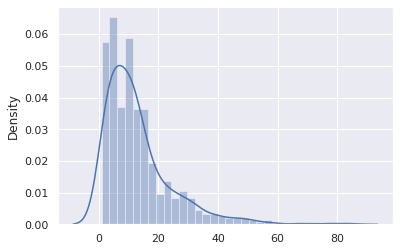

In [13]:
import matplotlib.pyplot as plt

def plot_distribution(counter):
    '''
    Plot the distribution stored in the counter object
    '''
    # prepare data
    import numpy as np
    labels, values = zip(*counter.items())
    indexes = np.arange(len(labels))

    # generate a plot
    import seaborn as sns
    sns.set(color_codes=True)
    sns.distplot(values)
    plt.show()

plot_distribution(p_distribution)

In [14]:
# write questions into file to generate embeddings
samples = mongo.get_sample(train=True, limit=limit)
os.chdir("/mpqa/KBQA/data/lcquad")
with open('questions.txt', 'w', encoding='utf-8') as fout:
    for doc in samples:
        fout.write(doc['question']+'\n')

In [15]:
# annotate types separately
loaded = False

verbose = False
limit = None

if not loaded:
    samples = mongo.get_sample(limit=limit)
    count = 0
    for doc in samples:
        # fix URI !
        sparql_query = doc['sparql_query']
        # parse the SPARQL query into spo triples
        tripples = sparql_query[sparql_query.find("{")+1:sparql_query.find("}")].split('. ')

        # collect entities and predicates separately for 2 hops
        classes = []
        cids = []
        for tripple in tripples:
            if tripple:
                entities = []
                s, p, o = tripple.strip().split()
#                     
                p = p[1:-1]
                if p == 'http://www.w3.org/1999/02/22-rdf-syntax-ns#type':
                    if o[0] != '?':
                        uri = o[1:-1]
                        classes.append(uri)
                        try:
                            cids.append(e_index.look_up_by_uri(uri)[0]['_source']['id'])
                        except:
                            print("%s not found in the entity catalog"%uri)
               
        if classes and verbose:
            print(sparql_query)
            print(classes)
            print(cids)
       
        doc['classes'] = classes
        doc['classes_ids'] = cids

        mongo.col.update_one({'_id': doc['_id']}, {"$set": doc}, upsert=True)
        count +=1

    print("%d documents annotated with entities and predicates URIs across hops"%count)

# show sample annotation
sample = mongo.get_by_id("2652").next()
print(sample['sparql_query'])
print(sample['classes'])
print(sample['classes_ids'])

4998 documents annotated with entities and predicates URIs across hops
SELECT DISTINCT ?uri WHERE {?uri <http://dbpedia.org/property/music> <http://dbpedia.org/resource/Akira_Ifukube>  . ?uri <http://www.w3.org/1999/02/22-rdf-syntax-ns#type> <http://dbpedia.org/ontology/Film>}
['http://dbpedia.org/ontology/Film']
[2979987]


## QALD-7

In [ ]:
mongo = Mongo_Connector('kbqa', 'qald_7_train')
data_path = "qald-7-train-multilingual.json"

ENDPOINT = 'https://dbpedia.org/sparql'

# load LC-QUAD dataset
loaded = False

if not loaded:
    import os
    os.chdir("/mpqa/KBQA/data/qald-7")

    import json
    import pprint
    import requests
    with open(data_path, encoding='utf-8') as f:
        dataset = json.load(f)
        for q in dataset['questions']:
            doc = {}
            doc['SerialNumber'] = q['id']
            doc['question'] = q['question'][0]['string']
            doc['sparql_query'] = q['query']['sparql'].replace('\n', ' ')
            response = requests.get(ENDPOINT, params={'query': doc['sparql_query'], 'output': 'json'}).json()
            if 'results' in response:
                results = response['results']['bindings']
                doc['answers'] = [v['value'] for r in results for v in r.values()]
            elif 'boolean' in response:
                doc['bool_answer'] = response['boolean']
            doc['train'] = False
            mongo.col.insert_one(doc)
            
mongo.count_all_docs()
doc = mongo.get_sample(train=False, limit=1)[0]
pprint.pprint(doc)
print(doc['sparql_query'])

In [ ]:
# parse the SPARQL query into spo triples
cursor = mongo.get_sample(limit=1)
with cursor:
    for doc in cursor:
        sparql_query = doc['sparql_query']
        print(sparql_query)
        tripples = sparql_query[sparql_query.find("{")+1:sparql_query.find("}")].split('. ')

        # collect entities and predicates
        for tripple in tripples:
            if tripple:
                entities, predicates = [], []
                clause = tripple.strip().split()
                if clause[0] != 'filter':
                    s, p, o = clause
                    if s[0] != '?':
                        entities.append(s)
                    if o[0] != '?':
                        entities.append(o)
                    predicates.append(p)
                print(entities)
                print(predicates)

## QALD-8

In [ ]:

mongo = Mongo_Connector('kbqa', 'qald_7_train')
data_path = "qald-7-train-multilingual.json"

ENDPOINT = 'https://dbpedia.org/sparql'

# load LC-QUAD dataset
loaded = False

if not loaded:
    import os
    os.chdir("/mpqa/KBQA/data/qald-7")

    import json
    import pprint
    import requests
    with open(data_path, encoding='utf-8') as f:
        dataset = json.load(f)
        for q in dataset['questions']:
            doc = {}
            doc['SerialNumber'] = q['id']
            doc['question'] = q['question'][0]['string']
            doc['sparql_query'] = q['query']['sparql'].replace('\n', ' ')
            response = requests.get(ENDPOINT, params={'query': doc['sparql_query'], 'output': 'json'}).json()
            if 'results' in response:
                results = response['results']['bindings']
                doc['answers'] = [v['value'] for r in results for v in r.values()]
            elif 'boolean' in response:
                doc['bool_answer'] = response['boolean']
            doc['train'] = False
            mongo.col.insert_one(doc)
            
mongo.count_all_docs()
doc = mongo.get_sample(train=False, limit=1)[0]
pprint.pprint(doc)
print(doc['sparql_query'])

# parse the SPARQL query into spo triples
cursor = mongo.get_sample(limit=1)
with cursor:
    for doc in cursor:
        sparql_query = doc['sparql_query']
        print(sparql_query)
        tripples = sparql_query[sparql_query.find("{")+1:sparql_query.find("}")].split('. ')

        # collect entities and predicates
        for tripple in tripples:
            if tripple:
                entities, predicates = [], []
                clause = tripple.strip().split()
                if clause[0] != 'filter':
                    s, p, o = clause
                    if s[0] != '?':
                        entities.append(s)
                    if o[0] != '?':
                        entities.append(o)
                    predicates.append(p)
                print(entities)
                print(predicates)